# Learning

This notebook serves as supporting material for topics covered in **Chapter 18 - Learning from Examples** , **Chapter 19 - Knowledge in Learning**, **Chapter 20 - Learning Probabilistic Models** from the book *Artificial Intelligence: A Modern Approach*. This notebook uses implementations from [learning.py](https://github.com/aimacode/aima-python/blob/master/learning.py). Let's start by importing everything from learning module.

In [1]:
from learning import *

## Review

In this notebook, we learn about agents that can improve their behavior through diligent study of their own experiences.

An agent is **learning** if it improves its performance on future tasks after making observations about the world.

There are three types of feedback that determine the three main types of learning:

* **Supervised Learning**:

In Supervised Learning the agent observeses some example input-output pairs and learns a function that maps from input to output.

**Example**: Let's think of an agent to classify images containing cats or dogs. If we provide an image containing a cat or a dog, this agent should output a string "cat" or "dog" for that particular image. To teach this agent, we will give a lot of input-output pairs like {cat image-"cat"}, {dog image-"dog"} to the aggent. The agent then learns a function that maps from an input image to one of those strings.

* **Unsupervised Learning**:

In Unsupervised Learning the agent learns patterns in the input even though no explicit feedback is supplied. The most common type is **clustering**: detecting potential useful clusters of input examples.

**Example**: A taxi agent would develop a concept of *good traffic days* and *bad traffic days* without ever being given labeled examples.

* **Reinforcement Learning**:

In Reinforcement Learning the agent from a series of reinforcements—rewards or punishments.

**Example**: Let's talk about an agent to play the popular Atari game—[Pong](http://www.ponggame.org). We will reward a point for every correct move and deduct a point for every wrong move from the agent. Eventually, the agent will figure out its actions prior to reinforcement were most responsible for it.

## Explanations of learning module goes here

# Practical Machine Learning Task

## MNIST handwritten digits calssification

The MNIST database, available from [this page](http://yann.lecun.com/exdb/mnist/) is a large database of handwritten digits that is commonly used for training & testing/validating in Machine learning.

The dataset has **60,000 training images** each of size 28x28 pixels with labels and **10,000 testing images** of size 28x28 pixels with labels.

In this section, we will use this database to compare performances of these different learning algorithms:
* kNN (k-Nearest Neighbour) classifier
* Single-hidden-layer Neural Network classifier
* SVMs (Support Vector Machines)

It is estimates that humans have an error rate of about **0.2%** on this problem. Let's see how our algorithms perform!

Let's start by loading MNIST data into numpy arrays.

In [2]:
import os, struct
import array
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
def load_MNIST(path="aima-data/MNIST"):
    "helper function to load MNIST data"
    train_img_file = open(os.path.join(path, "train-images-idx3-ubyte"), "rb")
    train_lbl_file = open(os.path.join(path, "train-labels-idx1-ubyte"), "rb")
    test_img_file = open(os.path.join(path, "t10k-images-idx3-ubyte"), "rb")
    test_lbl_file = open(os.path.join(path, 't10k-labels-idx1-ubyte'), "rb")
    
    magic_nr, tr_size, tr_rows, tr_cols = struct.unpack(">IIII", train_img_file.read(16))
    tr_img = array.array("B", train_img_file.read())
    train_img_file.close()    
    magic_nr, tr_size = struct.unpack(">II", train_lbl_file.read(8))
    tr_lbl = array.array("b", train_lbl_file.read())
    train_lbl_file.close()
    
    magic_nr, te_size, te_rows, te_cols = struct.unpack(">IIII", test_img_file.read(16))
    te_img = array.array("B", test_img_file.read())
    test_img_file.close()
    magic_nr, te_size = struct.unpack(">II", test_lbl_file.read(8))
    te_lbl = array.array("b", test_lbl_file.read())
    test_lbl_file.close()

#     print(len(tr_img), len(tr_lbl), tr_size)
#     print(len(te_img), len(te_lbl), te_size)
    
    train_img = np.zeros((tr_size, tr_rows*tr_cols), dtype=np.int16)
    train_lbl = np.zeros((tr_size,), dtype=np.int8)
    for i in range(tr_size):
        train_img[i] = np.array(tr_img[i*tr_rows*tr_cols : (i+1)*tr_rows*tr_cols]).reshape((tr_rows*te_cols))
        train_lbl[i] = tr_lbl[i]
        
    test_img = np.zeros((te_size, te_rows*te_cols), dtype=np.int16)
    test_lbl = np.zeros((te_size,), dtype=np.int8)
    for i in range(te_size):
        test_img[i] = np.array(te_img[i*te_rows*te_cols : (i+1)*te_rows*te_cols]).reshape((te_rows*te_cols))
        test_lbl[i] = te_lbl[i]
        
    return(train_img, train_lbl, test_img, test_lbl)

The function `load_MNIST()` loads MNIST data from files saved in `aima-data/MNIST`. It returns four numpy arrays that we are gonna use to train & classify hand-written digits in various learning approaches.

In [4]:
train_img, train_lbl, test_img, test_lbl = load_MNIST()

Check the shape of these NumPy arrays to make sure we have loaded the database correctly.

Each 28x28 pixel image is flattened to 784x1 array and we should have 60,000 of them in training data. Similarly we should have 10,000 of those 784x1 arrays in testing data. 

In [5]:
print("Training images size:", train_img.shape)
print("Training labels size:", train_lbl.shape)
print("Testing images size:", test_img.shape)
print("Training labels size:", test_lbl.shape)

Training images size: (60000, 784)
Training labels size: (60000,)
Testing images size: (10000, 784)
Training labels size: (10000,)


To get a better understanding of the dataset, let's visualize some random images for each class from training & testing datasets.

In [6]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)

def show_MNIST(dataset, samples=8):
    if dataset == "training":
        labels = train_lbl
        images = train_img
    elif dataset == "testing":
        labels = test_lbl
        images = test_img
    else:
        raise ValueError("dataset must be 'testing' or 'training'!")
        
    for y, cls in enumerate(classes):
        idxs = np.nonzero([i == y for i in labels])
        idxs = np.random.choice(idxs[0], samples, replace=False)
        for i , idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples, num_classes, plt_idx)
            plt.imshow(images[idx].reshape((28, 28)))
            plt.axis("off")
            if i == 0:
                plt.title(cls)


    plt.show()

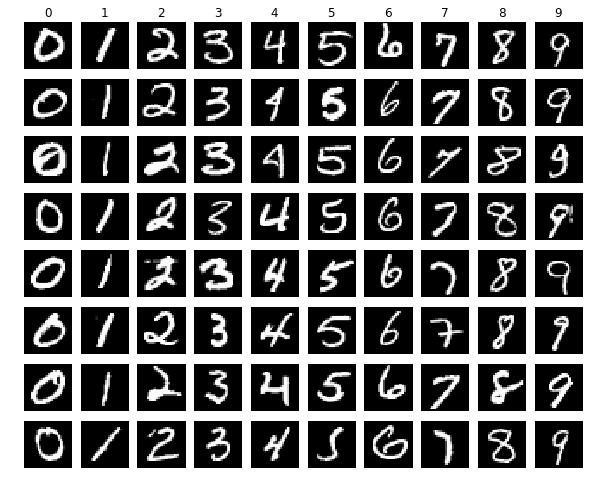

In [7]:
# takes 5-10 secs. to execute the cell
show_MNIST("training")

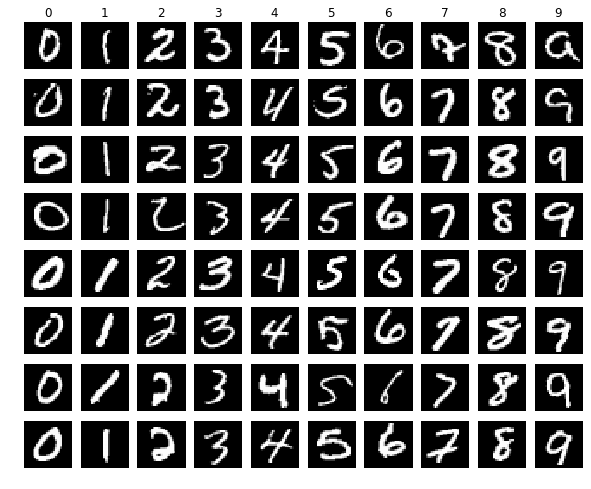

In [8]:
# takes 5-10 secs. to execute the cell
show_MNIST("testing")

Let's have a look at average of all the images of training and testing data.

In [9]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)

def show_ave_MNIST(dataset):
    if dataset == "training":
        print("Average of all images in training dataset.")
        labels = train_lbl
        images = train_img
    elif dataset == "testing":
        print("Average of all images in testing dataset.")
        labels = test_lbl
        images = test_img
    else:
        raise ValueError("dataset must be 'testing' or 'training'!")
        
    for y, cls in enumerate(classes):
        idxs = np.nonzero([i == y for i in labels])
        print("Digit", y, ":", len(idxs[0]), "images.")
        
        ave_img = np.mean(np.vstack([images[i] for i in idxs[0]]), axis = 0)
#         print(ave_img.shape)
        
        plt.subplot(1, num_classes, y+1)
        plt.imshow(ave_img.reshape((28, 28)))
        plt.axis("off")
        plt.title(cls)


    plt.show()

Average of all images in training dataset.
Digit 0 : 5923 images.
Digit 1 : 6742 images.
Digit 2 : 5958 images.
Digit 3 : 6131 images.
Digit 4 : 5842 images.
Digit 5 : 5421 images.
Digit 6 : 5918 images.
Digit 7 : 6265 images.
Digit 8 : 5851 images.
Digit 9 : 5949 images.


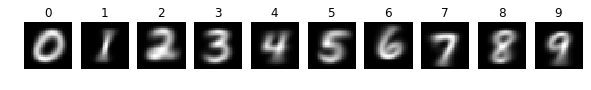

Average of all images in testing dataset.
Digit 0 : 980 images.
Digit 1 : 1135 images.
Digit 2 : 1032 images.
Digit 3 : 1010 images.
Digit 4 : 982 images.
Digit 5 : 892 images.
Digit 6 : 958 images.
Digit 7 : 1028 images.
Digit 8 : 974 images.
Digit 9 : 1009 images.


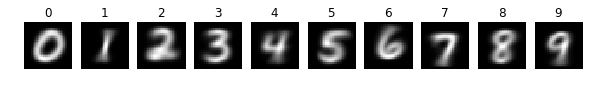

In [10]:
show_ave_MNIST("training")
show_ave_MNIST("testing")

## k-Nearest Neighbours (kNN) classifier

### Review
k-Nearest Neighbors algorithm is a non-parametric method used for classification and regression. We are gonna use this to classify MNIST handwritten digits. More about kNN on [Scholarpedia](http://www.scholarpedia.org/article/K-nearest_neighbor).

![kNN plot](images/knn_plot.png)

Let's see how kNN works with a simple plot shown in the above picture. There are two classes named **Class A** yellow color dots and **Class B** violet color dots. Every point in this plot has two **features** i.e. (X<sub>2</sub>, X<sub>1</sub>) values of that particular point which we used to plot. Now, let's say we have a new point, a red star and we want to know which class this red star belongs. Solving this problem by predicting the class of this new red star is out current classification problem.

We have co-ordinates (we call them **features** in ML) of this red star and we need to predict its class using kNN algorithm. In this algorithm, the value of **k** is arbitary. **k** is one of the **hyper parameters** for kNN algorithm. We choose this number based on our dataset and choosing a particular number is known as **hyper parameter tuning/optimising**. We learn more about this in coming topics.

Let's put **k = 3**. It means you need to find 3-Nearest Neighbors of this red star and classify this new point into majority class. Observe that smaller circle which containg 3 points other that **test point** (red star). As there are two violet points, which is majority, we predict the class of red star as **violet- Class B**.

Similarly if we put **k = 5**, you can observe that there are 4 yellow points, which is majority. So, we classify our test point as **yellow- Class A**.

In practical tasks, we iterate through a bunch of values for k (like [1, 2, 5, 10, 20, 50, 100]) and see how it performs and select the best one.

Let's classify MNIST data in this method. Similar to these points, our images in MNIST data also have **features**. These points have two features as (2, 3) which represents co-ordinates of the point in 2-dimentional plane. Our images have 28x28 pixel values and we treat them as **features** for this particular task. 

Next couple of cells help you understand some useful definitions from learning module. 

In [11]:
%psource DataSet

class DataSet explanation goes here

In [12]:
%psource NearestNeighborLearner

Nearest NeighborLearner explanation goes here

Now, let us convert this raw data into `Dataset.examples` to run our `NearestNeighborLearner(dataset, k=1)` defined in `learning.py`. Every image is represented by 784 numbers (28x28 pixels) and we append them with its label or class to make them work with our implementations in learning module.

In [13]:
print(train_img.shape, train_lbl.shape)
temp_train_lbl = train_lbl.reshape((60000,1))
training_examples = np.hstack((train_img, temp_train_lbl))
print(training_examples.shape)

(60000, 784) (60000,)
(60000, 785)


Now, we will initialize DataSet with our training examples. Call NearestNeighbor Learner on this dataset. Predict the class of a test image.

In [14]:
# takes ~8 Secs. to execute this cell
MNIST_DataSet = DataSet(examples=training_examples, distance=manhattan_distance)

In [15]:
kNN_Learner = NearestNeighborLearner(MNIST_DataSet)

Choose a number from 0 to 9999 and we are going to predict the class of that test image.

In [17]:
# takes ~20 Secs. to execute this cell
testing_choice = 2311
predicted_class = kNN_Learner(test_img[testing_choice])
print("Predicted class:", predicted_class)

Predicted class: 2


To make sure that the output we got is correct, let's plot that image along with its label.

2


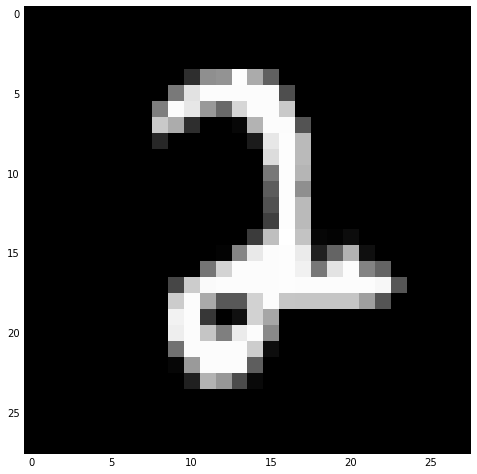

In [18]:
print(test_lbl[testing_choice])
plt.imshow(test_img[testing_choice].reshape((28,28)))

Hurray! We've got it correct. Don't worry if our algorithm predicted a wrong class. With this techinique we have only ~97% accuracy on this dataset. Let's try with a different test image and hope we get it this time.

You might have recognized that our algorithm took ~20 seconds to predict a single image. How would we even predict all 10,000 test images? Yeah, the implementations we have in our learning module are not optimized to run this particular dataset. We will have an optimised version below in numPy which is nearly ~10-50 times faster than this implementation.

### Faster kNN classifier implementation

In [19]:
class kNN_learner:
    def __init__():
        pass
    def train():
        pass
    def predict_labels():
        pass
    def compute_manhattan_distances():
        pass